# SW1PerS: Sliding Windows and 1-Persistence Scoring - Solutions

### MSRI-UP 2023

Authors: Jose Perea 

Date: 06/15/2023


---


### Activity: 

Write a python function which takes as input a time series $f$, enconded as a list or an array, a time delay $\tau > 0$, an embedding dimension $d \in \mathbb{N}$, a number of points `n_data`, and returns the corresponding sliding window point cloud   

---


<img src="https://i.ibb.co/3R9P6p7/SW.png" alt="test-1" border="0" width=650px>


In [52]:
import numpy as np
from scipy.interpolate import CubicSpline
from ripser import ripser
from persim import plot_diagrams

def SW_cloud(f, tau, d, n_data):
    # Step 1: Turn f into a cubic spline
    if f.shape[0] == 1:
        # If only y values are given, assume x values are 0, 1, 2, ...
        x_values = np.arange(f.shape[1])
        f = np.vstack((x_values, f))
    cs = CubicSpline(f[0], f[1])

    # Step 2: Create the t values where to evaluate SW_f
    t_values = np.linspace(f[0, 0], f[0, -1] - (d - 1) * tau, n_data)

    # Step 3: Evaluate the sliding window point cloud
    SW = np.zeros((n_data, d + 1))
    for i, t in enumerate(t_values):
        t_window = t + np.arange(d) * tau
        x_values = cs(t_window)
        SW[i] = np.concatenate(([t], x_values))
    
    return SW


The sliding window point cloud has shape (5000, 5)


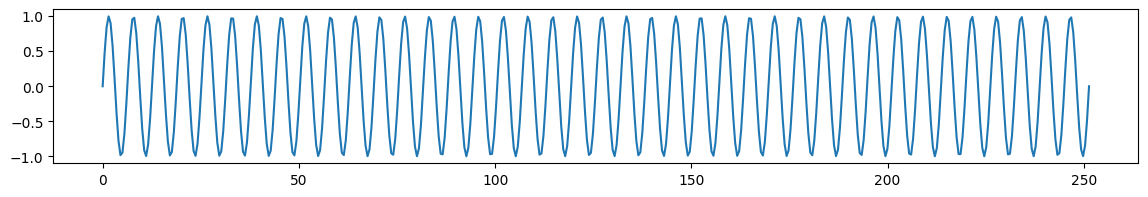

In [64]:
## Test it here
from matplotlib import pyplot as plt
x_vals = np.linspace(0 , 80*np.pi, 500)
y_vals = np.sin(x_vals) #+ 1.1*np.sin(np.sqrt(3)*x_vals) + x_vals/50

plt.figure(figsize = (14,2))
plt.plot(x_vals, y_vals);

f = np.array([x_vals, y_vals]) ## <---- toy time series
d = 4
tau = 1.5
n_data = 5000

SW = SW_cloud(f,tau, d, n_data )
print('The sliding window point cloud has shape', SW.shape)

In [65]:
from sklearn.decomposition import PCA
import plotly.graph_objects as go
from plotly.subplots import make_subplots

pca = PCA(n_components=5)
SW_pca = pca.fit(SW).transform(SW)

print('Explained Variance', pca.explained_variance_ratio_)

fig = go.Figure(data=[go.Scatter3d(
    x=SW_pca[:,0], y=SW_pca[:,1], z=SW_pca[:,2], 
    mode ='markers', 
    marker=dict(size = 1.5, color = 'grey')
)] , layout = go.Layout(scene = dict(aspectmode= 'data')))

fig.show()

Explained Variance [9.99606388e-01 2.11360925e-04 1.82251147e-04 1.21940995e-13
 1.00831056e-13]


### Not Periodic VS Periodic VS Quasiperiodic

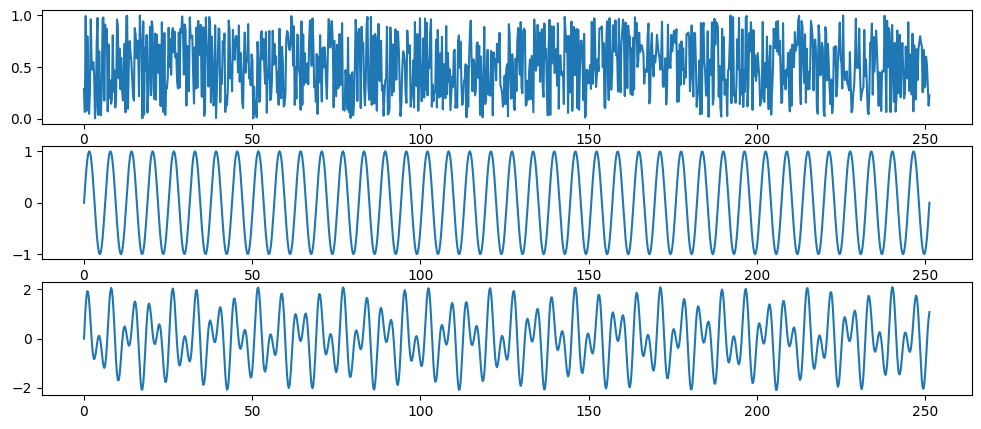

In [55]:
x_vals = np.linspace(0 , 80*np.pi, 1000)

y_not_per  = np.random.rand(len(x_vals))
y_per  = np.sin(x_vals)
y_qper  = np.sin(x_vals) + 1.1*np.sin(np.sqrt(3)*x_vals)

plt.figure(figsize = (12,5)) 
plt.subplot(3,1,1)
plt.plot(x_vals, y_not_per)

plt.subplot(3,1,2)
plt.plot(x_vals, y_per)

plt.subplot(3,1,3)
plt.plot(x_vals, y_qper)

In [56]:
# Slidng window point clouds

d = 4
tau = 1.5
n_data = 5000

f_not_per = np.array([x_vals, y_not_per])
SW_not_per = SW_cloud(f_not_per, tau, d, n_data )

f_per = np.array([x_vals, y_per])
SW_per = SW_cloud(f_per, tau, d, n_data )

f_qper = np.array([x_vals, y_qper])
SW_qper = SW_cloud(f_qper, tau, d, n_data )

In [57]:
# Persistent homology computations

n_landmarks = 200
prime_coeff = 7

rips_not_per = ripser(SW_not_per, n_perm = n_landmarks, coeff = prime_coeff, maxdim=2)
dgms_not_per = rips_not_per['dgms']

rips_per = ripser(SW_per, n_perm = n_landmarks, coeff = prime_coeff, maxdim=2)
dgms_per = rips_per['dgms']

rips_qper = ripser(SW_qper, n_perm = n_landmarks, coeff = prime_coeff, maxdim=2)
dgms_qper = rips_qper['dgms']


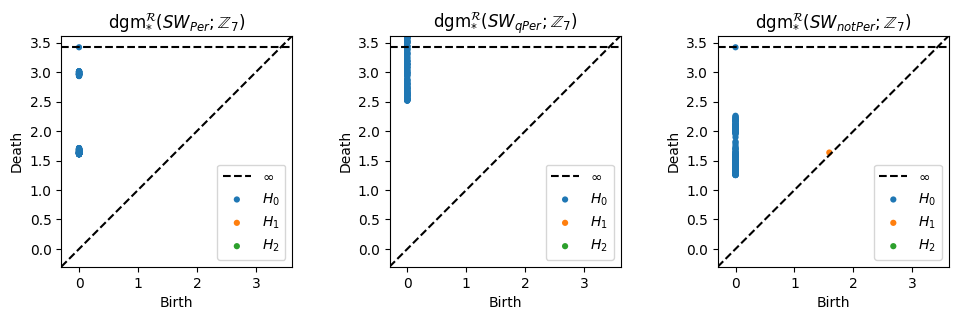

In [58]:
plt.figure(figsize = (12,3)) 
plt.subplot(1,3,1)
plot_diagrams(dgms_per)
plt.title('$\mathsf{dgm}^\mathcal{R}_{*}(SW_{Per}; \mathbb{Z}_{' + str(prime_coeff) +'})$');
x_left, x_right = plt.xlim()
y_left, y_right = plt.ylim()

plt.subplot(1,3,3)
plot_diagrams(dgms_not_per, xy_range  = [x_left, x_right, y_left, y_right] )
plt.title('$\mathsf{dgm}^\mathcal{R}_{*}(SW_{notPer}; \mathbb{Z}_{' + str(prime_coeff) +'})$');

plt.subplot(1,3,2)
plot_diagrams(dgms_qper, xy_range  = [x_left, x_right, y_left, y_right] )
plt.title('$\mathsf{dgm}^\mathcal{R}_{*}(SW_{qPer}; \mathbb{Z}_{' + str(prime_coeff) +'})$');
plt.show()

Explained Variance [9.99943758e-01 1.46752071e-05 1.44911947e-05 1.36622021e-05]
Explained Variance [9.99132558e-01 3.37971829e-04 3.03168230e-04 2.05930034e-04]


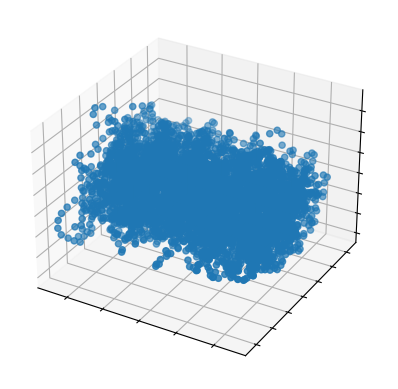

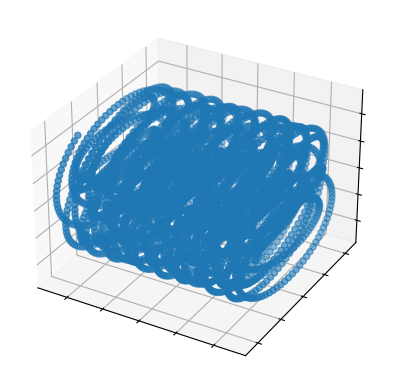

Explained Variance [9.99606318e-01 2.11398236e-04 1.82283980e-04 2.29891316e-16]


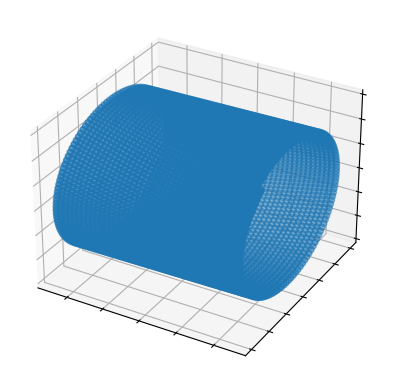

In [63]:
pca = PCA(n_components=4)
SW_pca = pca.fit(SW_not_per).transform(SW_not_per)

print('Explained Variance', pca.explained_variance_ratio_)

xs = SW_pca[:, 0]
ys = SW_pca[:, 1]
zs = SW_pca[:, 2]

# Plot
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.scatter(xs, ys, zs)

ax.set(xticklabels=[],
       yticklabels=[],
       zticklabels=[])

SW_pca = pca.fit(SW_qper).transform(SW_qper)

print('Explained Variance', pca.explained_variance_ratio_)

xs = SW_pca[:, 0]
ys = SW_pca[:, 1]
zs = SW_pca[:, 2]

# Plot
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.scatter(xs, ys, zs)

ax.set(xticklabels=[],
       yticklabels=[],
       zticklabels=[])
plt.show()

SW_pca = pca.fit(SW_per).transform(SW_per)

print('Explained Variance', pca.explained_variance_ratio_)

xs = SW_pca[:, 0]
ys = SW_pca[:, 1]
zs = SW_pca[:, 2]

# Plot
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.scatter(xs, ys, zs)

ax.set(xticklabels=[],
       yticklabels=[],
       zticklabels=[])

plt.show()

### Maximum persistence as periodicity score

Write a python function which computes $mp_1$. 
$$
mp_1 = \max \big\{ b - a \; : \; (a,b) \in \mathsf{dgm}_1(\mathcal{R}(\mathbb{SW}_{d,\tau} f))\big\}
$$


In [60]:
def max_pers(SW_cloud_result, dim=1):
    # Inputs:
    # SW_cloud_result: The result of the SW_cloud function
    
    #Step 1: Compute the Vietoris-Rips persistence diagram
    diagrams = ripser(SW_cloud_result, n_perm = n_landmarks, coeff = prime_coeff, maxdim=1)['dgms']
    #Step 2: Extract the 1-dimensional persistence pairs
    pairs = diagrams[dim]
    
    #Step 3: Compute mp_1
    mp_1 = 0
    for (a, b) in pairs:
        persistence = b - a
        mp_1 = max(mp_1, persistence)
    
    return mp_1

In [61]:
mp_1_value = max_pers(SW_not_per)
print("Not periodic mp_1:", mp_1_value)

mp_1_value = max_pers(SW_per)
print("Periodic mp_1:", mp_1_value)

mp_1_value = max_pers(SW_qper)
print("Quasiperiodic mp_1:", mp_1_value)

Not periodic mp_1: 0.044348835945129395
Periodic mp_1: 0
Quasiperiodic mp_1: 0.5708866119384766
